# Глубокое машинное обучение

## HW1: Computer Vision

Дата *мягкого* дедлайна: `22.10.2025 23:59`

Дата **жесткого** дедлйна: `29.10.2025 23:59`

### **Правила сдачи (обязательно к прочтению)**
- После **жесткого** дедлайна работы не принимаются.
- После мягкого дедлайна каждый день снимается 10 баллов.
- Все похожие друг на друга работы оцениваются в 0.
- Если вы использовали какой-то публичный код, то это необходимо указать в комментарии и приложить ссылку на источник, иначе тоже может быть 0. :(
- За нечитаемый код, неэффективную реализацию и _некрасивые_ визуализации могут быть сняты баллы.
- Все вычисления должны быть воспроизводимые, поэтому не забывайте про `seed=42`, а также не забудьте перезапустить ноутбук и прожать все ячейки - ошибок быть не должно.
- Готовый ноутбук со всеми данными необходимо положить в архив. В архив необходимо полдожить ваш requirments.txt со всеми версиями библиотек.
- Архив называется следующим образом: `HW1_<your_latin_name>.zip`. Пример: `HW1_malkov.zip`
- Для всех трейнов важно предоставить графики лосов/эпох. Легче всего оставить ссылку на wandb, если такой возможности нет, то делайте графики сами.
- Использовать LLM можно, но допускается не более 50% сгенерированного кода в каждом задании. В случае использования LLM нужно комментарием указать модель, промт и источник инференса. Если нет комментария или количество сгенерированного кода больше 50%, то за задание ставится 0. Пример:
```python
# LLM START
"""
Model: Qwen3-30B-A3B-FP8 (указать квантизацию и кастомные параметры (top-p, top-p, temperature, ...), если есть)
Source: vLLM (здесь может быть API (openrouter.ai), может быть сайт с чатиком (chat.z.ai), может быть тула для локального инференса (lm-studio), может быть TG-бот (@jadvebot))
Prompt: Мой китайский друг, представь, что ты Ян Ле Кун, придумай за меня алгоритм детекции тачулечек
"""
print("Hello world")
# LLM END
```


### **Правила оценки работы**
Всего за работу можно получить 50 баллов. Вся домашняя работа делится на Advanced (для сильных) и Regular _(для нормальных)_, каждый из разделов дает по 25 баллов. Только выполнив Advanced задачи, можно получить **отл**. Чтобы получить **хор** (5), достаточно полностью выполнить все Regular задания.
Вот как выглядит отображение баллов в оценки:
| [От и До) | Оценка |
|-----------|--------|
| 0-5       | 1      |
| 5-10      | 2      |
| 10-15     | 3      |
| 15-20     | 4      |
| 20-26     | 5      |
| 26-30     | 6      |
| 30-35     | 7      |
| 35-40     | 8      |
| 40-45     | 9      |
| 45-50     | 10     |

### Предисловие
Вы уже узнали столько, чтобы попробовать себя в роли настоящего инженера или даже ресерчера. Сегодня мы с нуля пройдем весь путь создания детектора. Наша задача будет заключаться в том, чтобы подготовить модель для детекции медицинских масок на изображении.\

![FaceMask](https://user-images.githubusercontent.com/49322948/159162461-4552eee3-27db-49b2-ab6c-718106adc3c7.jpg)

### 0. Импорт всего, что нужно, и определение всех констант

In [1]:
import cv2
import random
import math
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch, torchvision
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensorV2

from matplotlib import pyplot as plt
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torchvision.models.detection.ssdlite import SSDLiteClassificationHead, SSDLiteRegressionHead

BATCH_SIZE = 8
IMG_SIZE = 300
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

### (reg, 4.0) 1. Разметка

Здесь нет ссылки на датасет, потому что в реальной жизни данные вам, скорее всего, никто не даст. Вам нужно самим найти все необходимые данные и преобразовать их к нужному виду.

Готовую разметку необходимо подготовить в формате __Pascal VOC__.

__Ваш датасет нужно запаковать в архив и отправить вместе с работой!__

Ссылка на датасет: https://www.kaggle.com/datasets/humansintheloop/medical-mask-detection/data


In [2]:
import kagglehub

path = kagglehub.dataset_download("humansintheloop/medical-mask-detection")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'medical-mask-detection' dataset.
Path to dataset files: /kaggle/input/medical-mask-detection


In [3]:
!ls /kaggle/input/medical-mask-detection/Medical\ mask/'Medical Mask'
!cp /kaggle/input/medical-mask-detection/Medical\ mask/'Medical Mask' sample_data/ -r


annotations  images


In [4]:
!ls /content/sample_data/Medical\ Mask/annotations | wc -l

6024


In [5]:
!ls /content/sample_data/Medical\ Mask/images | wc -l

6017


In [168]:
import json
from pathlib import Path

def get_class_and_bb(path):
    json_file = open(path)
    data = json.load(json_file)
    result = []
    annotation_info = data['Annotations']
    for obj in annotation_info:
        class_name = obj['classname']
        if class_name == 'face_with_mask':
            result.append([1] + obj['BoundingBox'])

    return result

OBJECTS_DIR = Path('/content/sample_data/Medical Mask/')
IMAGES_DIR = OBJECTS_DIR / 'images'
ANNOTATIONS_DIR = OBJECTS_DIR / 'annotations'

# словарь путей - ключ: путь к файлу-картинке, значение: путь к аннотации
file_annotation = dict()

for file in IMAGES_DIR.iterdir():
    extensions = ['.png', '.jpg', '.jpeg']
    if file.name[-4:] in ['.jpg', '.png']:
        nums = file.name[0:len(file.name) - 4]
    else:
        nums = file.name[0:len(file.name) - 5]

    for ext in extensions:
        path = Path(str(ANNOTATIONS_DIR / nums) + ext + '.json')
        if path.exists():
            file_annotation[file] = path

images = []
targets = []

for file in file_annotation:
    annotation = file_annotation[file]
    class_and_bb = get_class_and_bb(annotation)
    images.append(file)
    targets.append(class_and_bb)

### 2. Подготовка датасета
О, ну вот и задание на код. Всё просто, нужно подготовить `dataset` и `loader`, которые будут использоваться для трейна и теста.

#### (reg, 1.0) 2.1 Определение датасета.


In [169]:
class MyVOCDataset(Dataset):
    def __init__(self, images, targets, device, transform=None):
        self.data = images
        self.target = targets
        self.transform = transform
        self.device = device

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path_to_image = self.data[idx]
        image = Image.open(path_to_image).convert('RGB')
        target = self.target[idx]

        if self.transform:
            bboxes = [bb[1:] for bb in target] if len(target) > 0 else []
            labels = [label[0] for label in target] if len(target) > 0 else []

            bboxes_safe = []
            labels_safe = []

            for i, bb in enumerate(bboxes):
                x1, y1, x2, y2 = bb
                if x2 > x1 and y2 > y1:
                    bboxes_safe.append(bb)
                    labels_safe.append(labels[i])


            transformed_data = self.transform(
                image=np.array(image),
                bboxes=bboxes_safe,
                labels=labels_safe
            )

            image_tensor = transformed_data['image'].float()
            bboxes_transformed = transformed_data['bboxes']
            labels_transformed = transformed_data['labels']

            bboxes_filtered = []
            labels_filtered = []

            for bb, lbl in zip(bboxes_transformed, labels_transformed):
                x1, y1, x2, y2 = bb
                if x2 > x1 and y2 > y1:
                    bboxes_filtered.append(bb)
                    labels_filtered.append(lbl)

            if len(bboxes_filtered) > 0:
                boxes_tensor = torch.tensor(bboxes_filtered, dtype=torch.float32)
                labels_tensor = torch.tensor(labels_filtered, dtype=torch.int64)
            else:
                boxes_tensor = torch.zeros((0, 4), dtype=torch.float32)
                labels_tensor = torch.zeros((0,), dtype=torch.int64)

            target_dict = {"boxes": boxes_tensor, "labels": labels_tensor}
            return image_tensor, target_dict

        image_tensor = transforms.ToTensor()(image).float()

        if len(target) > 0:
            boxes = torch.tensor([t[1:] for t in target], dtype=torch.float32)
            labels = torch.tensor([t[0] for t in target], dtype=torch.int64)
        else:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)

        target_dict = {"boxes": boxes, "labels": labels}
        return image_tensor, target_dict

#### (reg, 1.0) 2.2 Подготовка аугументации
Аугументацию необходимо делать с помощью `albumentations`.

In [170]:
train_transforms = A.Compose([
    A.PadIfNeeded(min_height=IMG_SIZE, min_width=IMG_SIZE, border_mode=0),
    A.OneOf([A.RandomCrop(width=IMG_SIZE, height=IMG_SIZE),
            A.RandomSizedBBoxSafeCrop(width=IMG_SIZE, height=IMG_SIZE),
            A.Resize(IMG_SIZE, IMG_SIZE) ], p=1.0),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    ToTensorV2() ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'], min_visibility=0.2, clip=True))

test_transforms = A.Compose([A.Resize(IMG_SIZE, IMG_SIZE), ToTensorV2()], bbox_params=A.BboxParams(format='pascal_voc',
                            label_fields=['labels'],
                            min_visibility=0.2,
                            clip=True))

#### 2.3 Cобираем всё вместе

In [171]:
def collate_fn(batch):
    images, targets = zip(*batch)

    return list(images), list(targets)

In [172]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_target, test_target = train_test_split(images, targets, shuffle=True, test_size=0.2, random_state=SEED)

train_dataset = MyVOCDataset(train_data, train_target, DEVICE, train_transforms)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=2, shuffle=True, collate_fn=collate_fn)

test_dataset = MyVOCDataset(test_data, test_target, DEVICE, test_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2, shuffle=False, collate_fn=collate_fn)

#### (reg, 0.5) 2.4 Визулизация датасета
Визуализируйте пару примеров, чтобы убедиться, что вы нигде не ошиблись в разметке.

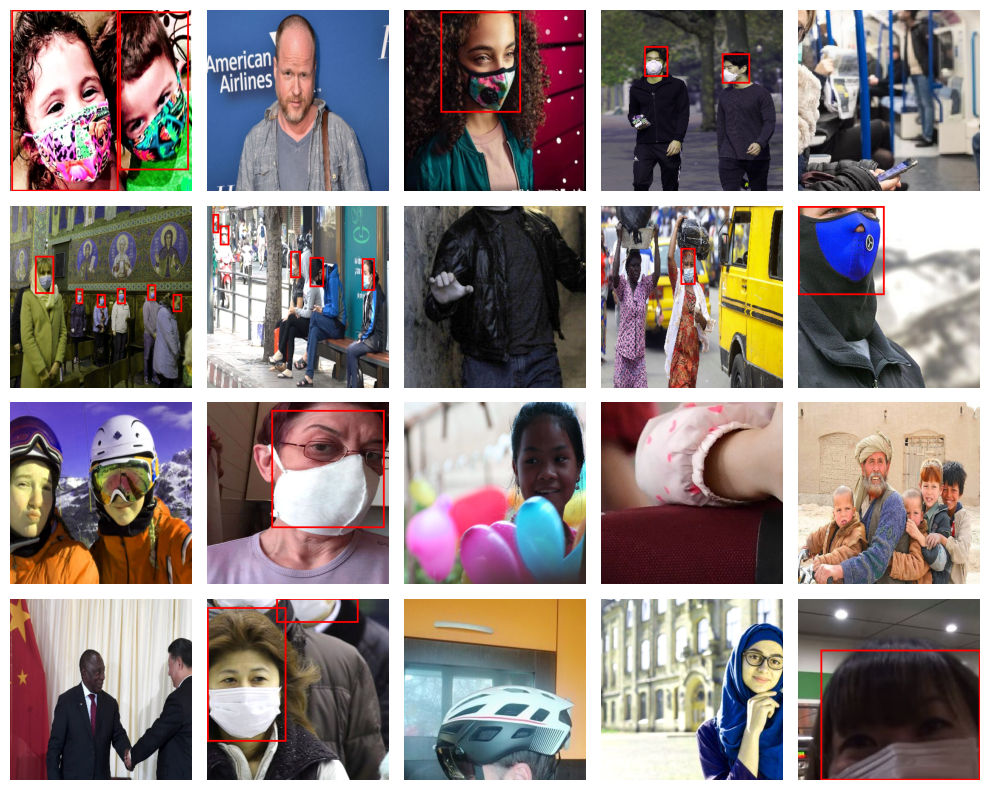

In [173]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
axes = axes.flatten()

for i in range(20):
  image_tensor, target_dict = train_dataset[i]
  boxes = target_dict["boxes"]

  img = image_tensor.cpu()
  img = img - img.min()
  img = img / img.max()
  img = (img * 255).byte()

  if boxes.numel() == 0:
        img_with_boxes = img
  else:
      img_with_boxes = draw_bounding_boxes(
          img, boxes.to(torch.int32), width=3, colors="red"
      )

  axes[i].imshow(img_with_boxes.permute(1, 2, 0).numpy())
  axes[i].axis("off")

plt.tight_layout()
plt.show()



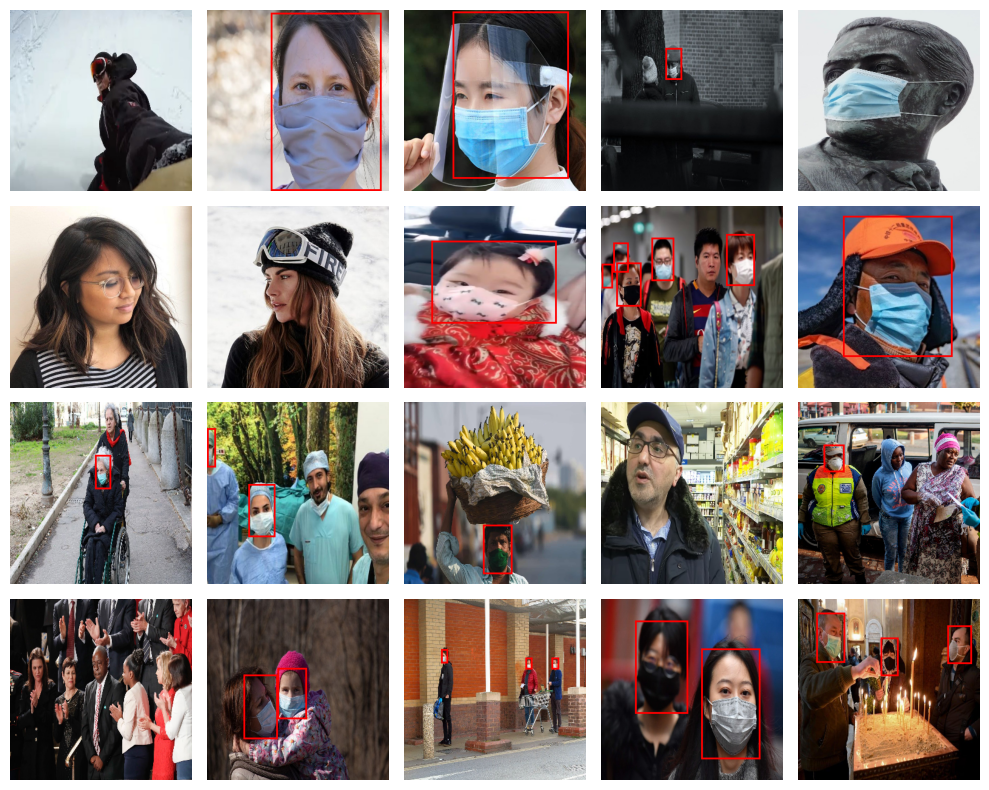

In [174]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
axes = axes.flatten()

for i in range(20):
  image_tensor, target_dict = test_dataset[i]
  boxes = target_dict["boxes"]

  img = image_tensor.cpu()
  img = img - img.min()
  img = img / img.max()
  img = (img * 255).byte()

  if boxes.numel() == 0:
        img_with_boxes = img
  else:
      img_with_boxes = draw_bounding_boxes(
          img, boxes.to(torch.int32), width=3, colors="red"
      )

  axes[i].imshow(img_with_boxes.permute(1, 2, 0).numpy())
  axes[i].axis("off")

plt.tight_layout()
plt.show()



### 3. Обучение претрейн модели
Очень вам завидую, ведь это ваш первый настоящий трейн!

В прошлом курсе вы уже обучали бустинги и, может даже, с какими-нибудь сложными `hyperopt` или `gridsearch`, но поверьте — это совсем не то. В этом задании вам пригодится абсолютно всё, что мы к этому времени прошли, + мощности colab/kaggle/... + много времени и терпения. А всё почему? А всё потому, что мы будем с вами реализовывать **SSD** с нуля без каких-либо претрейнов и без VGG в бэкбоне (это всё-таки пережиток прошлого). Ну и сравним, что у нас получится с реализацией из `torchvision`, если всё сойдется.

#### 3.0 Теоретическая вводная.

Мы уже обсуждали на лекции, что такое SSD, и если кратко, то это One-Stage детектор, аналогичный YOLO, в котором есть несколько трюков:
1. Берут готовый бэкбон (VGG16), а не обучают его с нуля на ImageNet.
2. Вместо FC слоев используют только свертки. (прям как в RPN Faster-RCNN)
3. Из оригинальной VGG убирают все полносвязные слои и добавляют дополнительно 5 слоев сверток.
4. Вместо одного последнего слоя/активации (как в YOLO) берут 6 слоев из разных мест сети и «делают на них предсказания». Нужно это для того, чтобы лучше работать с объектами маленьких размеров, с которыми YOLO работает плохо.

Если более простыми словами объяснять проблематику из пункта 4, то в случае YOLO мы после всех преобразований оригинального изображения 448х448(x3) мы получаем карту активации 7x7(x1024). Таким образом, для каждого 64x64 квадрата оригинального изображения мы имеем всего 1x1x1024 фичи, характеризующий каждый из квадратов 64x64, при этом пространственной информации о содержании этих квадратов там почти нет. Зато пространственной информации будет больше на более ранних картах активации, например, размера 32х32, где каждый «элемент сетки» уже будет отвечать за квадрат 14x14 оригинального изображения. При этом, очевидно, «фичи» из карты активации 32х32 будут «слабее» фичей из 7х7, просто потому что слой 7х7 глубже.

![SSD](https://www.acetrace.app/images/illustrations/ssd.png)

Если всё ещё не очень понятно, что в этом вашем SSD происходит, то обязательно посмотрите вот на этот реп: [клик](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection).

#### 3.1 Практическая вводная
Первое, что вам нужно сделать, — это прочитать [статью](https://arxiv.org/pdf/1512.02325) с вниманием ко всем деталям. Оттуда, например, нужно заимствовать формулки для расчета скейла: $s_k = s_{min} + \frac{s_{max}-s_{min}}{m-1}(k-1)$ и узнать про _hard negative mining_ (все нюансы из статьи правда важны, её же не глупые люди писали!).

Какие-то детали с точки зрения имплементации можно подчерпнуть из:
- [официальной имплементации](https://github.com/weiliu89/caffe/blob/2c4e4c2899ad7c3a997afef2c1fbac76adca1bad/examples/ssd/ssd_coco.py).
- [популярной учебной имплементации](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/model.py).
- [имплементации команды torch](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/ssd.py).
- [просто чья-то имплементация](https://github.com/amdegroot/ssd.pytorch/tree/master).

Также очень рекомендую прочитать блог команды torch относительно имплементации SSD и SSD-Lite (это SSD с MobileNet в бэкбоне):
- [SSD](https://pytorch.org/blog/torchvision-ssd-implementation/).
- [SSD-Lite](https://pytorch-hub-preview.netlify.app/blog/torchvision-ssdlite-implementation/).

#### **3.2 План действий (обязательно к прочтению)**
Теперь по поводу плана. Если вы не GPU-rich и не имеете доступа к серверу хотя бы с 4 GPU, то у вас вряд ли получится сделать претрейн SSD с нуля, чтобы она прям была пригодна для использования, поэтому мы с вами сфокусируемся на самой архитектуре и на непосредственно процессе обучения. Пункт с обучением своей модели будет выполнен, если:
1. Всё в вашей имплементации будет по делу.
2. Ваша имплементация будет спокойно **переобучаться** на одном батче за 1000 итераций. Это значит, что вы все правильно имплементировали.
3. У вас будет хотя бы **10-20 эпох**, где видно, что лосс классификации и лосс регрессии уверенно сходятся. При этом вам нужно показать минимум **пять** конфигураций обучения (с разными гиперпараметрами/лосами/оптимизациями/архитектурными триками).

Если вы все сделали всё правильно, то на ваших графиках loss-а вы увидите что-то такое:
<div>
<img src="https://d3e0luujhwn38u.cloudfront.net/resized/kz9vKVmfahkZKS5UC_tJ8SJVHjeHIGDO8X-wiz8PzU8/s:3200/plain/s3://typefully-user-uploads/img/original/36777/1e59208e-44c4-4ed1-9c13-ee0010afc4cb.png" width="500"/>
</div>

Теперь пару советов с точки зрения самой реализации:
1. Бэкбон предлагаю брать максимально компактный типа MobileNetV3.
2. Предлагаю не брать какой-то большой датасет типа [COCO](https://public.roboflow.com/object-detection/microsoft-coco-subset/2), а ограничится [PASCAL VOC](https://public.roboflow.com/object-detection/pascal-voc-2012/1).
3. Здорово, если вы в какой-то имплементации увидите, что авторы используют SGD, а в другой использует какие трики с масштабированием дисперсии, но будьте уверены, в вашем случае это может не работать или работать не очень хорошо. Нужно все проверять самостоятельно.  

Куда обязательно нужно посмотреть:
1. Уменьшения изображения — это ок для нашего домашнего претрейна.
2. Инициализация весов — это очень важно.
3. Сильный дисбаланс классов надо в любом случае компенсировать.

И несколько практических советов:
1. Обязательно делайте чекпоинты во время трейна.
2. Старайтесь сделать код максимально гибким и удобным для ваших экспериментов, а не копипастить одну и ту же функцию трейна с разными оптимизаторами.
3. Внимательно смотрите не только на значения лосов по эпохам, но по всем итерациям/степам — это сэкономит вам время.
4. Обязательно логируйте все эксперименты в тексте/тензорборде/wandb и смотрите графики. Не забывайте делать оценку на val-выборке, особенно если используете не очень большой датасет типа PASCAL.

#### (adv, 5.0) 3.3 Определение модели
VGG, скорее всего, очень сильно отличается по архитектуре от выбранного вами бэкбона, поэтому вам самостоятельно нужно подобрать слои, из которых брать фичи, а также определить количество анкеров и базовые соотношения сторон боксов.

Для того чтобы долго не высчитывать, какой размер сверток вам нужен на каждом этапе, лучше просто посмотреть, какие шейпы получаются на каждом слое. Вот пример кода:
```python
backbone = torchvision.models.get_model("mobilenet_v3_large", weights="DEFAULT").features
x = torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE)
for i, layer in enumerate(backbone):
    x = layer(x)
    print('back', i, x.shape)

extra_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(960, 256, 1, bias=False), nn.BatchNorm2d(256), nn.ReLU6(inplace=True),
                SeparableConv2d(256, 512, kernel_size=3, stride=2, padding=1)
            ),
            nn.Sequential(
                nn.Conv2d(512, 128, 1, bias=False), nn.BatchNorm2d(128), nn.ReLU6(inplace=True),
                SeparableConv2d(128, 256, kernel_size=3, stride=2, padding=1)
            ),
        ])

for i, layer in enumerate(extra_layers):
    x = layer(x)
    print('ext', i, x.shape)
```

In [ ]:
# взято отсюда https://www.codegenes.net/blog/separableconv2d-pytorch/

class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(SeparableConv2d, self).__init__()
        # Depthwise convolution
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size,
                                   stride=stride, padding=padding, groups=in_channels)
        # Pointwise convolution
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x


In [ ]:
backbone = torchvision.models.get_model("mobilenet_v3_large", weights="DEFAULT").features
x = torch.randn(1, 3, IMG_SIZE, IMG_SIZE)
for i, layer in enumerate(backbone):
    x = layer(x)
    print('back', i, x.shape)

extra_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(960, 256, 1, bias=False), nn.BatchNorm2d(256), nn.ReLU6(inplace=True),
                SeparableConv2d(256, 512, kernel_size=3, stride=2, padding=1)
            ),
            nn.Sequential(
                nn.Conv2d(512, 128, 1, bias=False), nn.BatchNorm2d(128), nn.ReLU6(inplace=True),
                SeparableConv2d(128, 256, kernel_size=3, stride=2, padding=1)
            ),
            nn.Sequential(
                nn.Conv2d(256, 128, 1, bias=False), nn.BatchNorm2d(128), nn.ReLU6(inplace=True),
                SeparableConv2d(128, 128, kernel_size=3, stride=2, padding=1)
            ),
            nn.Sequential(
                nn.Conv2d(128, 64, 1, bias=False), nn.BatchNorm2d(64), nn.ReLU6(inplace=True),
                SeparableConv2d(64, 64, kernel_size=3, stride=2, padding=1)
            ),
        ])

for i, layer in enumerate(extra_layers):
    x = layer(x)
    print('ext', i, x.shape)

back 0 torch.Size([1, 16, 150, 150])
back 1 torch.Size([1, 16, 150, 150])
back 2 torch.Size([1, 24, 75, 75])
back 3 torch.Size([1, 24, 75, 75])
back 4 torch.Size([1, 40, 38, 38])
back 5 torch.Size([1, 40, 38, 38])
back 6 torch.Size([1, 40, 38, 38])
back 7 torch.Size([1, 80, 19, 19])
back 8 torch.Size([1, 80, 19, 19])
back 9 torch.Size([1, 80, 19, 19])
back 10 torch.Size([1, 80, 19, 19])
back 11 torch.Size([1, 112, 19, 19])
back 12 torch.Size([1, 112, 19, 19])
back 13 torch.Size([1, 160, 10, 10])
back 14 torch.Size([1, 160, 10, 10])
back 15 torch.Size([1, 160, 10, 10])
back 16 torch.Size([1, 960, 10, 10])
ext 0 torch.Size([1, 512, 5, 5])
ext 1 torch.Size([1, 256, 3, 3])
ext 2 torch.Size([1, 128, 2, 2])
ext 3 torch.Size([1, 64, 1, 1])


Судя по выводу выше, мы должны взять фич мапы после 4, 7, 13 слоя и наши самописные слои 0, 1, 3

In [ ]:
class MySSD(nn.Module):
    def __init__(self, num_classes=21):
        super().__init__()
        self.num_classes = num_classes
        self.aspect_ratios = [
          [ 1., 2., 0.5, 1. ],
          [ 1., 2., 3., 0.5, .333, 1. ],
          [ 1., 2., 3., 0.5, .333, 1. ],
          [ 1., 2., 3., 0.5, .333, 1. ],
          [ 1., 2., 0.5, 1. ],
          [ 1., 2., 0.5, 1. ]
        ]

        backbone = torchvision.models.get_model("mobilenet_v3_large", weights="DEFAULT").features
        self.backbone = backbone
        self.backbone_feature_layers = [4, 7, 13]

        self.extra_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(960, 256, 1, bias=False), nn.BatchNorm2d(256), nn.ReLU6(inplace=True),
                SeparableConv2d(256, 512, kernel_size=3, stride=2, padding=1)
            ),
            nn.Sequential(
                nn.Conv2d(512, 128, 1, bias=False), nn.BatchNorm2d(128), nn.ReLU6(inplace=True),
                SeparableConv2d(128, 256, kernel_size=3, stride=2, padding=1)
            ),
            nn.Sequential(
                nn.Conv2d(256, 128, 1, bias=False), nn.BatchNorm2d(128), nn.ReLU6(inplace=True),
                SeparableConv2d(128, 128, kernel_size=3, stride=2, padding=1)
            ),
            nn.Sequential(
                nn.Conv2d(128, 64, 1, bias=False), nn.BatchNorm2d(64), nn.ReLU6(inplace=True),
                SeparableConv2d(64, 64, kernel_size=3, stride=2, padding=1)
            ),
        ])

        self.extra_feature_layers = [0, 1, 3]
        self.size_of_features = [38, 19, 10, 5, 3, 1]

        self.cls_heads = nn.ModuleList()
        self.bbox_reg_heads = nn.ModuleList()

        out_channels = [40, 80, 160, 512, 256, 64]
        for channels, ar in zip(out_channels, self.aspect_ratios):
          self.cls_heads.append(nn.Conv2d(channels, num_classes*(len(ar)+1), 3, padding=1))
          self.bbox_reg_heads.append(nn.Conv2d(channels, 4*(len(ar)+1), 3, padding=1))

        for layer in self.extra_layers.modules():
          if isinstance(layer, nn.Conv2d):
            torch.nn.init.xavier_uniform_(layer.weight)
            if layer.bias is not None:
              torch.nn.init.constant_(layer.bias, 0.0)

        for module in self.cls_heads:
          torch.nn.init.xavier_uniform_(module.weight)
          if module.bias is not None:
            torch.nn.init.constant_(module.bias, 0.0)

        for module in self.bbox_reg_heads:
          torch.nn.init.xavier_uniform_(module.weight)
          if module.bias is not None:
            torch.nn.init.constant_(module.bias, 0.0)

        self.default_boxes = self._generate_default_boxes()



    def _generate_default_boxes(self, s_min=0.1, s_max=0.9):
        """
        Функция генерации дефолтных боксов, как из статьи
        """
        len_of_features = len(self.backbone_feature_layers) + len(self.extra_feature_layers)

        default_boxes = []
        scales = [0] * len_of_features
        for k in range(len_of_features):
          scales[k] = s_min + ((s_max - s_min) * k) / (len_of_features - 1)
        scales.append(1.05)
        for k in range(len_of_features):
          size = self.size_of_features[k]
          for i in range(size):
            for j in range(size):
              x_c = (i + 0.5) / size
              y_c = (j + 0.5) / size
              for ar in self.aspect_ratios[k]:
                w = scales[k] * math.sqrt(ar)
                h = scales[k] / math.sqrt(ar)
                default_boxes.append([x_c, y_c, w, h])
              s_add = math.sqrt(scales[k] * scales[k + 1])
              default_boxes.append([x_c, y_c, s_add, s_add])


        voc_dboxes = []
        for i in range(len(default_boxes)):
          dbox = default_boxes[i]
          x_c, y_c, w, h = dbox
          x1 = x_c - 0.5 * w
          y1 = y_c - 0.5 * h
          x2 = x_c + 0.5 * w
          y2 = y_c + 0.5 * h
          voc_dboxes.append(torch.tensor([x1, y1, x2, y2]))


        return voc_dboxes

    def forward(self, x):
        output_features = []
        for i, layer in enumerate(self.backbone):
            x = layer(x)
            if i in self.backbone_feature_layers:
              output_features.append(x)
        for i, layer in enumerate(self.extra_layers):
            x = layer(x)
            if i in self.extra_feature_layers:
              output_features.append(x)

        locs = []
        confs = []
        for feature, loc_head, cls_head in zip(output_features, self.bbox_reg_heads, self.cls_heads):
          locs.append(loc_head(feature).permute(0, 2, 3, 1).contiguous())
          confs.append(cls_head(feature).permute(0, 2, 3, 1).contiguous())

        locs = torch.cat([o.view(o.size(0), -1, 4) for o in locs], dim=1)
        confs = torch.cat([o.view(o.size(0), -1, self.num_classes) for o in confs], dim=1)

        return locs, confs

#### (adv, 2.0) 3.4 Определение лоса
В оригинальной статье лосс состоит из двух компонет: лосс регрессии (L1_smooth) и лосс классификации (кросс-энтропия) с трюком Hard negative mining.

In [ ]:
class MySSDLoss(nn.Module):
    def __init__(self, iou_threshold=0.5, alpha=1.0, neg_pos_ratio=3):
        super().__init__()
        self.iou_threshold = iou_threshold
        self.alpha = alpha
        self.neg_pos_ratio = neg_pos_ratio

    def calculate_iou(self, boxes1, boxes2):
      if boxes1.numel() == 0 or boxes2.numel() == 0:
          return torch.zeros((boxes1.size(0), boxes2.size(0)), device=boxes1.device)

      boxes1 = boxes1.unsqueeze(1)
      boxes2 = boxes2.unsqueeze(0)

      inter_x1 = torch.max(boxes1[...,0], boxes2[...,0])
      inter_y1 = torch.max(boxes1[...,1], boxes2[...,1])
      inter_x2 = torch.min(boxes1[...,2], boxes2[...,2])
      inter_y2 = torch.min(boxes1[...,3], boxes2[...,3])

      inter_w = (inter_x2 - inter_x1).clamp(min=0)
      inter_h = (inter_y2 - inter_y1).clamp(min=0)
      inter_area = inter_w * inter_h

      area1 = (boxes1[...,2]-boxes1[...,0])*(boxes1[...,3]-boxes1[...,1])
      area2 = (boxes2[...,2]-boxes2[...,0])*(boxes2[...,3]-boxes2[...,1])
      union = area1 + area2 - inter_area

      ious = inter_area / (union + 1e-6)
      return ious

    def encode_boxes(self, gt_boxes, default_boxes):
        eps = 1e-6

        g_cx = (gt_boxes[:, 0] + gt_boxes[:, 2]) / 2.0
        g_cy = (gt_boxes[:, 1] + gt_boxes[:, 3]) / 2.0
        g_w = (gt_boxes[:, 2] - gt_boxes[:, 0]).clamp(min=eps)
        g_h = (gt_boxes[:, 3] - gt_boxes[:, 1]).clamp(min=eps)

        d_cx = (default_boxes[:, 0] + default_boxes[:, 2]) / 2.0
        d_cy = (default_boxes[:, 1] + default_boxes[:, 3]) / 2.0
        d_w = (default_boxes[:, 2] - default_boxes[:, 0]).clamp(min=eps)
        d_h = (default_boxes[:, 3] - default_boxes[:, 1]).clamp(min=eps)

        tx = (g_cx - d_cx) / d_w
        ty = (g_cy - d_cy) / d_h
        tw = torch.log(g_w / d_w)
        th = torch.log(g_h / d_h)

        return torch.stack([tx, ty, tw, th], dim=1)


    def forward(self, pred_locs, pred_confs, default_boxes, targets):
        batch_size = pred_locs.size(0)
        num_boxes = pred_locs.size(1)
        num_classes = pred_confs.size(2)
        default_boxes = torch.stack(default_boxes).to(pred_locs.device) * IMG_SIZE

        loc_targets = torch.zeros_like(pred_locs)
        conf_targets = torch.zeros(batch_size, num_boxes, dtype=torch.long, device=pred_locs.device)

        # Matching
        for i in range(batch_size):
          target = targets[i]
          if target['boxes'].size(0) == 0:
              continue
          gt_boxes = target['boxes']
          gt_labels = target['labels']

          iou = self.calculate_iou(gt_boxes, default_boxes)

          best_iou, best_gt_idx = iou.max(dim=0)

          conf_targets[i] = gt_labels[best_gt_idx]
          conf_targets[i][best_iou < self.iou_threshold] = 0

          pos_mask = best_iou >= self.iou_threshold
          best_iou, best_gt_idx = iou.max(dim=0)

          pos_mask = best_iou >= self.iou_threshold
          if pos_mask.sum() > 0:
              matched_gt_boxes = gt_boxes[best_gt_idx[pos_mask]]
              matched_default_boxes = default_boxes[pos_mask]
              loc_targets[i, pos_mask] = self.encode_boxes(matched_gt_boxes, matched_default_boxes)

        # Localization loss (Smooth L1)
        pos_mask = conf_targets > 0
        loc_loss = F.smooth_l1_loss(pred_locs[pos_mask], loc_targets[pos_mask], reduction='sum')

        # Confidence loss (CrossEntropy + Hard Negative Mining)
        conf_loss_all = F.cross_entropy(pred_confs.view(-1, num_classes),
                                        conf_targets.view(-1),
                                        reduction='none').view(batch_size, num_boxes)

        conf_loss = 0

        for i in range(batch_size):
          positive_loss = conf_loss_all[i][pos_mask[i]].sum()

          # Hard negative mining
          num_positive = pos_mask[i].sum()
          num_negative = min(self.neg_pos_ratio * num_positive, num_boxes - num_positive)

          if num_negative > 0:
            negative_loss = conf_loss_all[i][~pos_mask[i]]
            if negative_loss.numel() > 0:
              negative_loss, _ = torch.sort(negative_loss, descending=True)
              negative_loss = negative_loss[:num_negative].sum()
            else:
              negative_loss = 0
          else:
            negative_loss = torch.tensor(0., device=pred_locs.device, requires_grad=True)

          conf_loss = conf_loss + positive_loss + negative_loss

        num_pos_total = pos_mask.sum()
        if num_pos_total > 0:
            loc_loss /= num_pos_total
            conf_loss /= num_pos_total
        else:
            loc_loss = torch.tensor(0., device=pred_locs.device, requires_grad=True)
            conf_loss = torch.tensor(0., device=pred_locs.device, requires_grad=True)

        total_loss = conf_loss + self.alpha * loc_loss
        return total_loss, conf_loss, loc_loss

#### (adv, 1.0) 3.5 Аугументация для претрейна

In [ ]:
pre_train_transforms = A.Compose([
    A.PadIfNeeded(min_height=IMG_SIZE, min_width=IMG_SIZE, border_mode=0),
    A.OneOf([
        A.RandomCrop(width=IMG_SIZE, height=IMG_SIZE),
        A.RandomSizedBBoxSafeCrop(width=IMG_SIZE, height=IMG_SIZE),
        A.Resize(IMG_SIZE, IMG_SIZE)
    ], p=1.0),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

pre_val_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

pre_test_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

#### (adv, 1.0) 3.6 Подготовка датасета и лоудера для претрейна
> Нужно обязательно переисользовать `MyVOCDataset`.

In [ ]:
def collate_fn(batch):
    images = torch.stack([b[0] for b in batch])
    targets = [b[1] for b in batch]
    return images, targets

In [ ]:
pre_train_data, pre_middle_data, pre_train_target, pre_middle_target = train_test_split(images, targets, shuffle=True, test_size=0.3, random_state=SEED)

pre_val_data, pre_test_data, pre_val_target, pre_test_target = train_test_split(pre_middle_data, pre_middle_target, shuffle=True, test_size=0.5, random_state=SEED)

pre_train_dataset = MyVOCDataset(pre_train_data, pre_train_target, DEVICE, pre_train_transforms)
pre_train_loader = DataLoader(pre_train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

pre_val_dataset = MyVOCDataset(pre_val_data, pre_val_target, DEVICE, pre_val_transforms)
pre_val_loader = DataLoader(pre_val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

pre_test_dataset = MyVOCDataset(pre_test_data, pre_test_target, DEVICE, pre_test_transforms)
pre_test_loader = DataLoader(pre_test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

#### (reg, 2.0) 3.7 Визулизация датасета
Визуализируйте пару примеров, чтобы убедиться, что вы нигде не ошиблись в разметке.

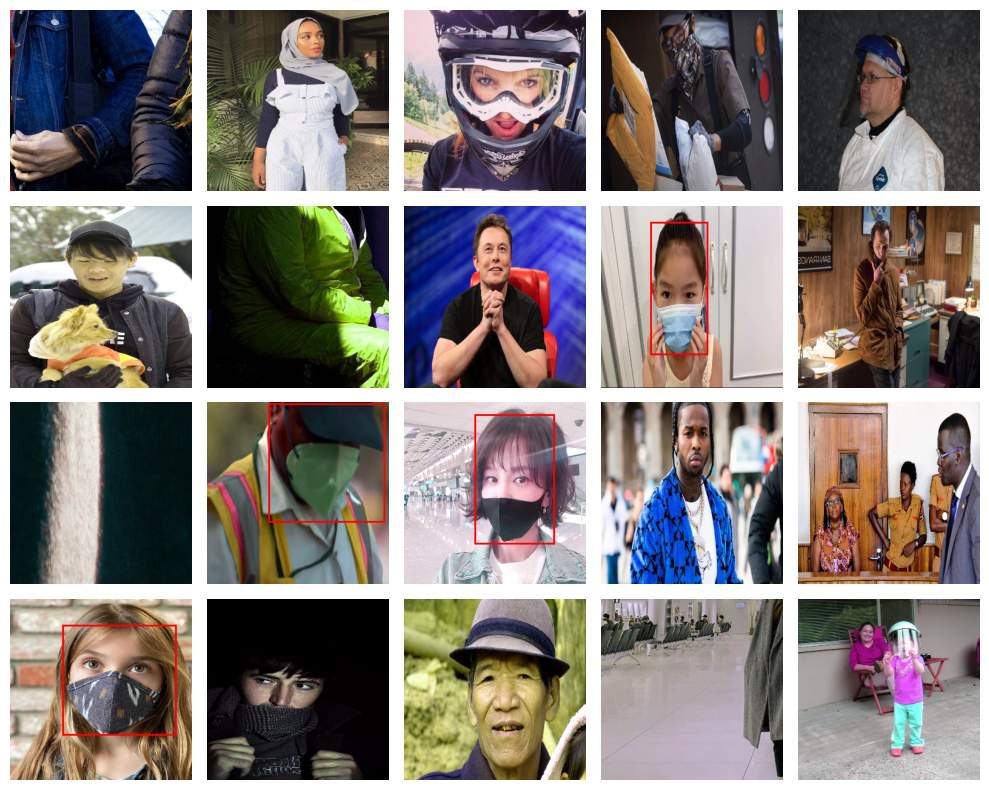

In [ ]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
axes = axes.flatten()

for i in range(20):
  image_tensor, target_dict = pre_train_dataset[i]
  boxes = target_dict["boxes"]

  img = image_tensor.cpu()
  img = img - img.min()
  img = img / img.max()
  img = (img * 255).byte()

  if boxes.numel() == 0:
        img_with_boxes = img
  else:
      img_with_boxes = draw_bounding_boxes(
          img, boxes.to(torch.int32), width=3, colors="red"
      )

  axes[i].imshow(img_with_boxes.permute(1, 2, 0).numpy())
  axes[i].axis("off")

plt.tight_layout()
plt.show()



#### (adv, 1.0) 3.8 Подготовка train-loop для переобученя на одном батче
> Не забывайте про перевод модели в режим трнйна (`model.train()`) или в режим инференса (`model.eval()`), а также помните про контекстный менджер: (`torch.no_grad()`).

In [ ]:
def run_single_batch_overfit(model, optim, criterion, dataloader, device, iterations=1500):
    model.train()
    data, targets = next(iter(dataloader))
    data = data.to(device)
    targets = [
        {
            "boxes": t["boxes"].to(device),
            "labels": t["labels"].to(device)
        }
        for t in targets
    ]

    total_losses = []
    conf_losses = []
    loc_losses = []

    for it in range(iterations):
        optim.zero_grad()
        loc_preds, conf_preds = model(data)
        loss, conf_loss, loc_loss = criterion(loc_preds, conf_preds, model.default_boxes, targets)
        loss.backward()
        optim.step()

        if it % 100 == 0 or it == 1:
            print(
                f"Iter [{it}/{iterations}] | "
                f"Total Loss: {loss.item():.4f} | "
                f"Conf Loss: {conf_loss.item():.4f} | "
                f"Loc Loss: {loc_loss.item():.4f}"
            )
            total_losses.append(loss.item())
            conf_losses.append(conf_loss.item())
            loc_losses.append(loc_loss.item())

    print(f"Finished overfitting single batch. Average Loss: {sum(total_losses) / iterations:.4f}")

    return total_losses, conf_losses, loc_losses

#### (adv, 2.0) 3.9 Оверфит на одном батче

In [ ]:
model = MySSD().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
criterion = MySSDLoss()
total_loss, conf_loss, loc_loss = run_single_batch_overfit(model, optimizer, criterion, pre_train_loader, device=DEVICE)

Iter [0/1500] | Total Loss: 64.5725 | Conf Loss: 56.9744 | Loc Loss: 7.5980
Iter [1/1500] | Total Loss: 60.2434 | Conf Loss: 53.0761 | Loc Loss: 7.1673
Iter [100/1500] | Total Loss: 8.3700 | Conf Loss: 8.3559 | Loc Loss: 0.0141
Iter [200/1500] | Total Loss: 1.7218 | Conf Loss: 1.7126 | Loc Loss: 0.0092
Iter [300/1500] | Total Loss: 1.1015 | Conf Loss: 1.0976 | Loc Loss: 0.0039
Iter [400/1500] | Total Loss: 0.7915 | Conf Loss: 0.7883 | Loc Loss: 0.0033
Iter [500/1500] | Total Loss: 0.6780 | Conf Loss: 0.6751 | Loc Loss: 0.0029
Iter [600/1500] | Total Loss: 0.5950 | Conf Loss: 0.5924 | Loc Loss: 0.0026
Iter [700/1500] | Total Loss: 0.5001 | Conf Loss: 0.4977 | Loc Loss: 0.0023
Iter [800/1500] | Total Loss: 0.3841 | Conf Loss: 0.3820 | Loc Loss: 0.0021
Iter [900/1500] | Total Loss: 0.2871 | Conf Loss: 0.2853 | Loc Loss: 0.0018
Iter [1000/1500] | Total Loss: 0.2259 | Conf Loss: 0.2244 | Loc Loss: 0.0015
Iter [1100/1500] | Total Loss: 0.1752 | Conf Loss: 0.1742 | Loc Loss: 0.0011
Iter [1200

#### (adv, 1.0) 3.10 Визуализация экспериментов

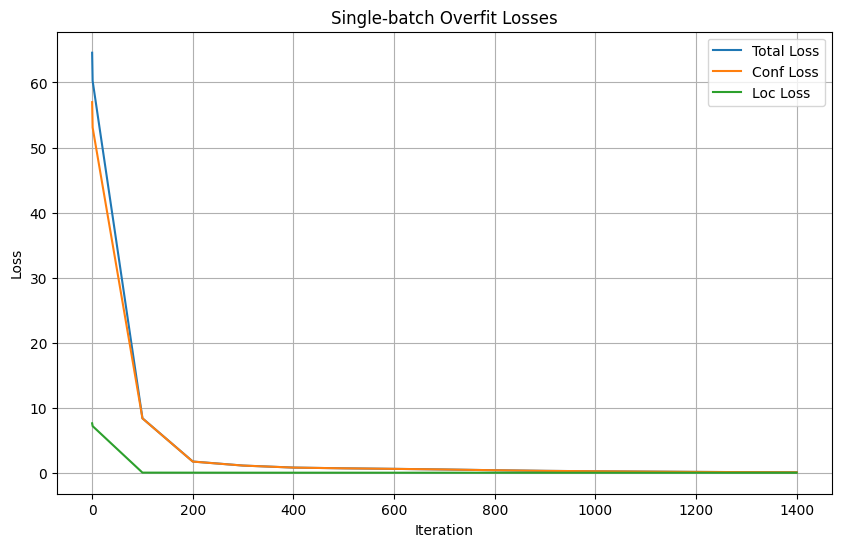

In [ ]:
iters = [0, 1, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400]

plt.figure(figsize=(10,6))
plt.plot(iters, total_loss, label="Total Loss")
plt.plot(iters, conf_loss, label="Conf Loss")
plt.plot(iters, loc_loss, label="Loc Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Single-batch Overfit Losses")
plt.legend()
plt.grid(True)
plt.show()

#### (adv, 1.0) 3.11 Подготовка train-loop для обучения претрейна


In [ ]:
def run_training_stage(model, optimizer, criterion, train_loader, val_loader=None,
                       device='cpu', num_epochs=10):
    model.to(device)

    steps_loss = []
    total_loss_list = []
    conf_loss_list = []
    loc_loss_list = []

    val_total_loss_list = []
    val_conf_loss_list = []
    val_loc_loss_list = []

    n = len(train_loader)

    for epoch in range(num_epochs):
      model.train()
      loss = 0.0
      conf_loss = 0.0
      loc_loss = 0.0

      for batch_id, (images, targets) in enumerate(train_loader):
        images = images.to(device)
        targets = [
        {
            "boxes": t["boxes"].to(device),
            "labels": t["labels"].to(device)
        }
        for t in targets]

        optimizer.zero_grad()
        pred_locs, pred_confs = model(images)
        cur_loss, cur_conf_loss, cur_loc_loss = criterion(pred_locs, pred_confs, model.default_boxes, targets)
        cur_loss.backward()
        optimizer.step()
        steps_loss.append(cur_loss.item())

        loss = loss + cur_loss.item()
        conf_loss = conf_loss + cur_conf_loss.item()
        loc_loss = loc_loss + cur_loc_loss.item()

        if (batch_id + 1) % 100 == 0:
                print(f"[Epoch {epoch}/{num_epochs}] Step {batch_id+1}/{len(train_loader)} | "
                      f"Total Loss: {loss/(batch_id+1):.4f} | "
                      f"Conf Loss: {conf_loss/(batch_id+1):.4f} | "
                      f"Loc Loss: {loc_loss/(batch_id+1):.4f}")

        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            val_conf_loss = 0.0
            val_loc_loss = 0.0
            with torch.no_grad():
                for images, targets in val_loader:
                    images = images.to(device)
                    targets = [t.to(device) for t in targets]
                    pred_locs, pred_confs = model(images)
                    loss, conf_loss, loc_loss = criterion(pred_locs, pred_confs, model.default_boxes, targets)
                    val_loss =  val_loss + loss.item()
                    val_conf_loss = val_conf_loss + conf_loss.item()
                    val_loc_loss = val_loc_loss + loc_loss.item()

            val_total_loss_list.append(val_loss / len(val_loader))
            val_conf_loss_list.append(val_conf_loss / len(val_loader))
            val_loc_loss_list.append(val_loc_loss / len(val_loader))

            print(f"Validation: Total {val_total_loss_list[-1]:.4f} | "
              f"Conf {val_conf_loss_list[-1]:.4f} | Loc {val_loc_loss_list[-1]:.4f}")

      total_loss_list.append(loss / n )
      conf_loss_list.append(conf_loss / n)
      loc_loss_list.append(loc_loss / n)

      epoch_loss = loss / n
      print(f"==> Epoch {epoch}/{num_epochs} finished. Avg Loss: {epoch_loss:.4f}")


    if val_loader is not None:
      return steps_loss, total_loss_list, conf_loss_list, loc_loss_list, val_total_loss_list, val_conf_loss_list, val_loc_loss_list
    return steps_loss, total_loss_list, conf_loss_list, loc_loss_list

#### (adv, 8.0) 3.12 Обучение претрейна
> Не нужно ждать, что все сойдется, достаточно просто показать 5 разных конфигураций обучения с 20-30 эпохами, где лосс _уверенно_ падает.

In [ ]:
model = MySSD().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
criterion = MySSDLoss()
step_loss, total_loss_list, conf_loss_list, loc_loss_list = run_training_stage(model, optimizer, criterion, pre_train_loader, device=DEVICE, num_epochs=12)

[Epoch 0/12] Step 100/527 | Total Loss: 37.8511 | Conf Loss: 31.8056 | Loc Loss: 6.0456
[Epoch 0/12] Step 200/527 | Total Loss: 29.6028 | Conf Loss: 25.0792 | Loc Loss: 4.5237
[Epoch 0/12] Step 300/527 | Total Loss: 23.9426 | Conf Loss: 20.2515 | Loc Loss: 3.6911
[Epoch 0/12] Step 400/527 | Total Loss: 19.8704 | Conf Loss: 16.7205 | Loc Loss: 3.1499
[Epoch 0/12] Step 500/527 | Total Loss: 16.9974 | Conf Loss: 14.3510 | Loc Loss: 2.6464
==> Epoch 0/12 finished. Avg Loss: 16.3967
[Epoch 1/12] Step 100/527 | Total Loss: 5.6026 | Conf Loss: 4.9671 | Loc Loss: 0.6354
[Epoch 1/12] Step 200/527 | Total Loss: 5.6424 | Conf Loss: 5.0315 | Loc Loss: 0.6109
[Epoch 1/12] Step 300/527 | Total Loss: 5.4788 | Conf Loss: 4.9186 | Loc Loss: 0.5602
[Epoch 1/12] Step 400/527 | Total Loss: 5.4442 | Conf Loss: 4.8972 | Loc Loss: 0.5469
[Epoch 1/12] Step 500/527 | Total Loss: 5.4135 | Conf Loss: 4.8734 | Loc Loss: 0.5401
==> Epoch 1/12 finished. Avg Loss: 5.3708
[Epoch 2/12] Step 100/527 | Total Loss: 4.620

#### (adv, 1.0) 3.13 Визуализация экспериментов

In [ ]:
def visualize(step_loss, total_loss, conf_loss, loc_loss):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    axes[0].plot(step_loss, label="Train Loss per Step")
    axes[0].set_xlabel("Step")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Loss per Step")
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(total_loss, label="Total loss per Epoch", marker='o')
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].set_title("Total loss per Epoch")
    axes[1].legend()
    axes[1].grid(True)

    axes[2].plot(conf_loss, label="Confidence loss per Epoch", marker='o')
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("Loss")
    axes[2].set_title("Confidence loss per Epoch")
    axes[2].legend()
    axes[2].grid(True)

    axes[3].plot(loc_loss, label="Localization loss per Epoch", marker='o')
    axes[3].set_xlabel("Epoch")
    axes[3].set_ylabel("Loss")
    axes[3].set_title("Localization loss per Epoch")
    axes[3].legend()
    axes[3].grid(True)


    plt.tight_layout()
    plt.show()

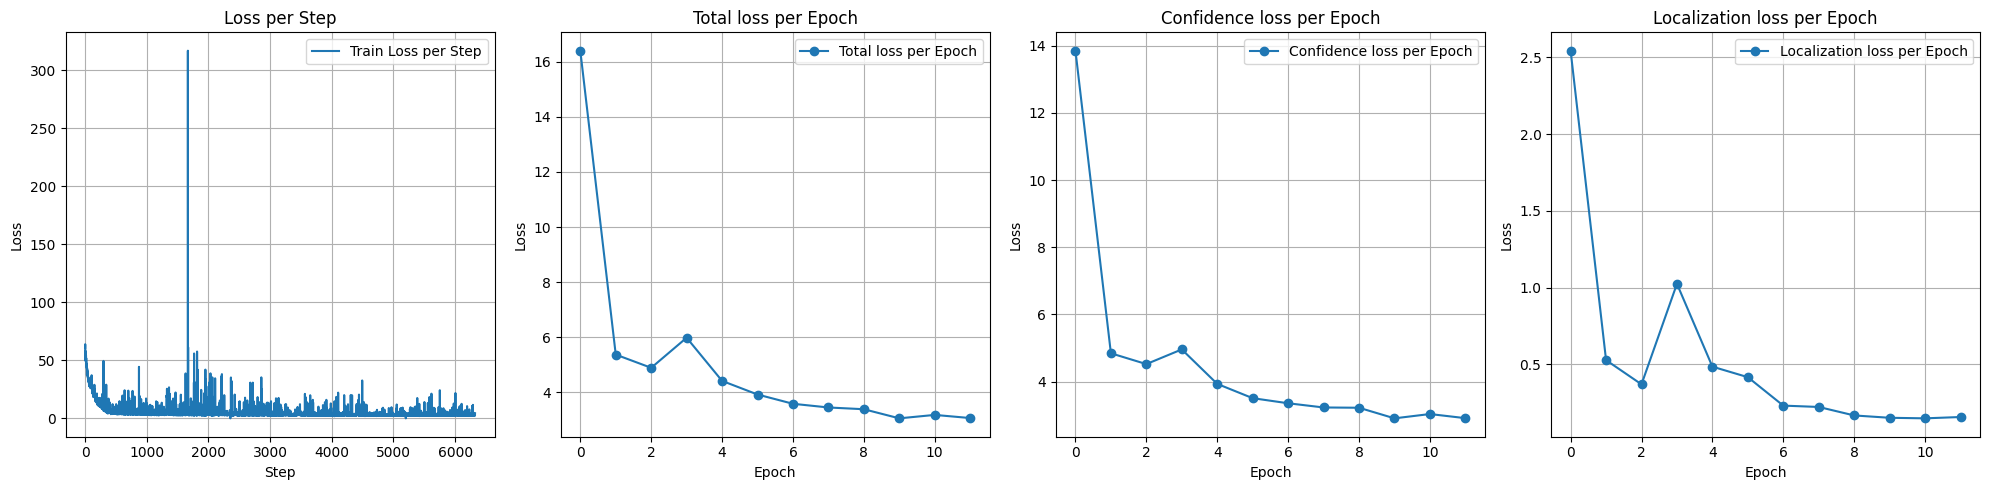

In [ ]:
visualize(step_loss, total_loss_list, conf_loss_list, loc_loss_list)

Если вы дошли до этого пункта, то вы просто герой! („• ֊ •„)੭

По секрету: если на собеседовании вы скажете, что вы _Senior AI Developer_, то никто даже не поймет подвоха.

### 4. Обучение основной модели на базе готового претрейна
В этом блоке мы зафайнтюним предобученную SSD-Lite на нашей собственной разметке.

#### (reg, 1.0) 4.1 Импортируйте веса модели
Вот сразу ссылка на сурсы, если что: [клик](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/ssdlite.py). Для вас задача ещё сложнее: дефолтно в [SSD](https://github.com/pytorch/vision/blob/7a13ad0f89167089616b51f4fd07f978cf1f17e4/torchvision/models/detection/ssd.py#L453) и [SSD-Lite](https://github.com/pytorch/vision/blob/7a13ad0f89167089616b51f4fd07f978cf1f17e4/torchvision/models/detection/ssdlite.py#L310) включен NMS, а нам надо его выключить, потому что мы сделаем его сами. Напомнию, что NMS на этапе обучения __[не нужен](https://github.com/pytorch/vision/blob/7a13ad0f89167089616b51f4fd07f978cf1f17e4/torchvision/models/detection/ssd.py#L404)__.

In [ ]:
model = ssdlite320_mobilenet_v3_large(weights="DEFAULT")

#### (reg, 4.0) 4.1 Подготовьте train-loop

In [175]:
import torch
from tqdm import tqdm

def train(model, optimizer, scheduler, train_loader, device='cpu', num_epochs=15):
    torch.backends.cudnn.benchmark = True
    model.to(device)

    steps_loss_list = []
    total_loss_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for images, targets in pbar:

            images = [img.to(device, non_blocking=True) for img in images]
            for t in targets:
              t["boxes"] = t["boxes"].to(device, non_blocking=True)
              t["labels"] = t["labels"].to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs = model(images, targets)
            loss = sum(outputs.values())
            loss.backward()
            optimizer.step()
            scheduler.step()

            steps_loss_list.append(loss.item())
            running_loss += loss.item()
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})

        # if scheduler is not None:
        #   scheduler.step()

        epoch_loss = running_loss / len(train_loader)
        total_loss_list.append(epoch_loss)
        print(f"[Epoch {epoch+1}/{num_epochs}] Train loss: {epoch_loss:.4f}")

    return steps_loss_list, total_loss_list

#### (reg, 3.0) 4.2 Обучите модель на нашем датасете

In [ ]:
model1 = ssdlite320_mobilenet_v3_large(weights="DEFAULT")
model1.to(DEVICE)
optimizer = torch.optim.SGD(model1.parameters(), lr=1e-3, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
steps_loss, total_loss = train(model1, optimizer, scheduler, train_loader, device=DEVICE)

[Epoch 1/15] Train loss: 3.8055


Epoch 2/15:  15%|█▌        | 91/602 [00:14<01:50,  4.62it/s, loss=4.2615]

In [ ]:
modes = {1 : "SGD, lr = 1e-3",
         2 : "SGD, lr = 1e-4",
         3 : "SGD, lr = 1e-2",
         4 : "SGD, momentum = 0.95",
         5 : "Adam, lr = 1e-3"
         }

def train_mode(mode):
  model = ssdlite320_mobilenet_v3_large(weights="DEFAULT")
  model.to(DEVICE)
  if mode == 1:
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9) # SGD, lr = 1e-3
  if mode == 2:
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9) # SGD, lr = 1e-4
  if mode == 3:
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9) # SGD, lr = 1e-2
  if mode == 4:
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.95) # SGD, momentum = 0.95
  if mode == 5:
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Adam, lr = 1e-3
  steps_loss, total_loss = train(model, optimizer, train_loader, device=DEVICE)
  return model, steps_loss, total_loss

In [ ]:
for mode in list(modes.keys())[1:]:
  print(f"Training mode: {modes[mode]}")
  model, steps_loss, total_loss = train_mode(mode)
  steps_losses.append(steps_loss)
  total_losses.append(total_loss)
  models.append(model)

Training mode: SGD, lr = 1e-3


[Epoch 1/10] Train loss: 2.5512


[Epoch 2/10] Train loss: 2.1047


[Epoch 3/10] Train loss: 1.9691


[Epoch 4/10] Train loss: 1.9266


[Epoch 5/10] Train loss: 1.8552


[Epoch 6/10] Train loss: 1.7848


[Epoch 7/10] Train loss: 1.7617


[Epoch 8/10] Train loss: 1.7357


[Epoch 9/10] Train loss: 1.7063


[Epoch 10/10] Train loss: 1.6928
Training mode: SGD, lr = 1e-2


[Epoch 1/10] Train loss: 3.2697


[Epoch 2/10] Train loss: 2.6787


[Epoch 3/10] Train loss: 2.4555


[Epoch 4/10] Train loss: 2.3435


[Epoch 5/10] Train loss: 2.2480


[Epoch 6/10] Train loss: 2.1824


[Epoch 7/10] Train loss: 2.0808


[Epoch 8/10] Train loss: 2.0550


[Epoch 9/10] Train loss: 2.0631


[Epoch 10/10] Train loss: 2.0076
Training mode: SGD, momentum = 0.95


[Epoch 1/10] Train loss: 2.6869


[Epoch 2/10] Train loss: 2.2068


[Epoch 3/10] Train loss: 2.0456


[Epoch 4/10] Train loss: 1.9474


[Epoch 5/10] Train loss: 1.8968


[Epoch 6/10] Train loss: 1.8518


[Epoch 7/10] Train loss: 1.8098


[Epoch 8/10] Train loss: 1.7926


[Epoch 9/10] Train loss: 1.7521


[Epoch 10/10] Train loss: 1.6964
Training mode: Adam, lr = 1e-3


[Epoch 1/10] Train loss: 2.7381


[Epoch 2/10] Train loss: 2.3512


[Epoch 3/10] Train loss: 2.2835


[Epoch 4/10] Train loss: 2.1471


[Epoch 5/10] Train loss: 2.0722


[Epoch 6/10] Train loss: 2.0605


[Epoch 7/10] Train loss: 2.0032


[Epoch 8/10] Train loss: 1.9775


[Epoch 9/10] Train loss: 1.9857


[Epoch 10/10] Train loss: 1.9369


#### (reg, 2.0) 4.3 Визуализация эксперимента

In [ ]:
def visualize(step_loss, epoch_loss, mode):
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    axes[0].plot(step_loss, label="Train Loss per Step")
    axes[0].set_xlabel("Step")
    axes[0].set_ylabel("Loss")
    axes[0].set_title(f"Loss per Step, mode: {mode}")
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(epoch_loss, label="Avg Loss per Epoch", marker='o')
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].set_title(f"Average Loss per Epoch, mode: {mode}")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

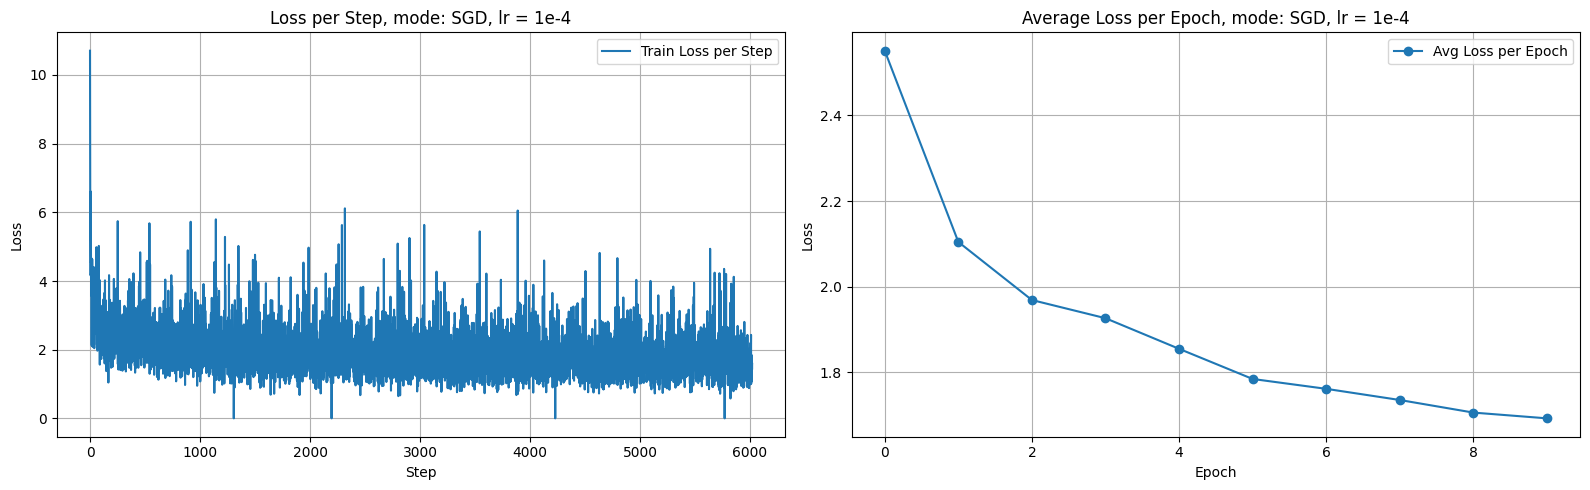

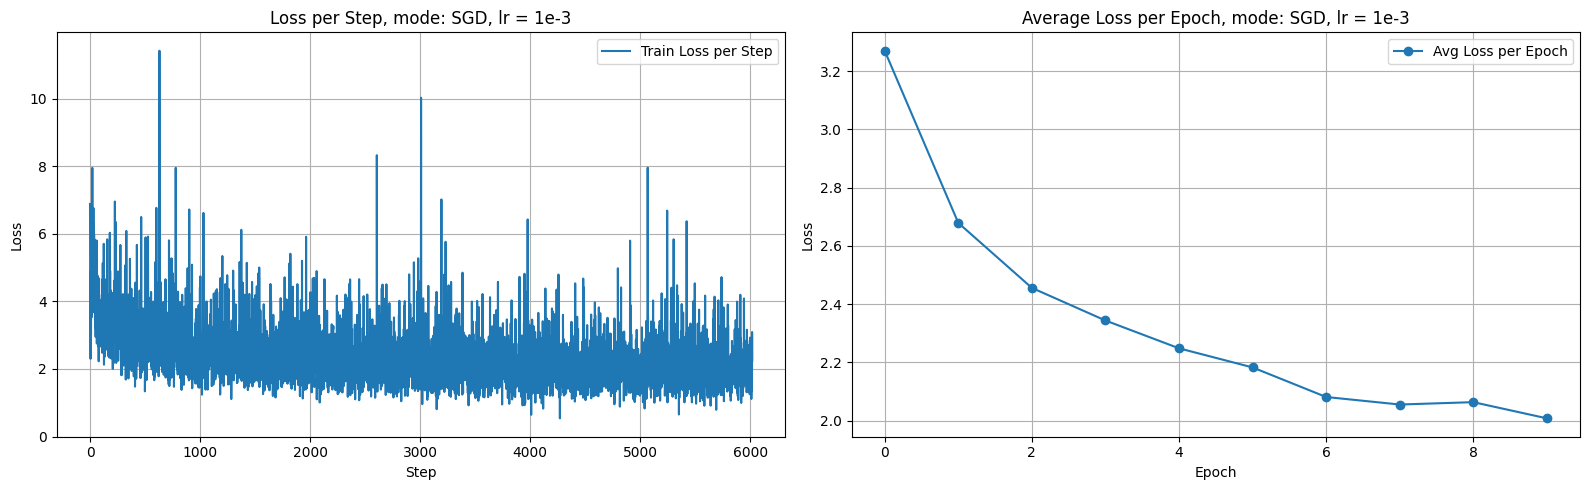

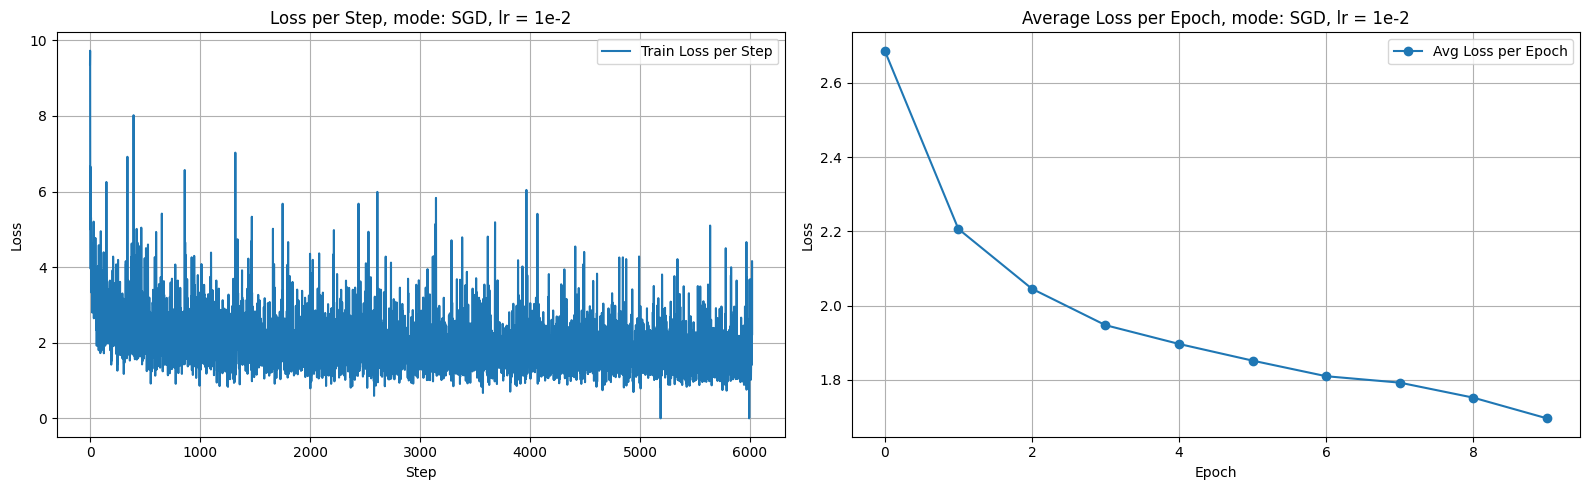

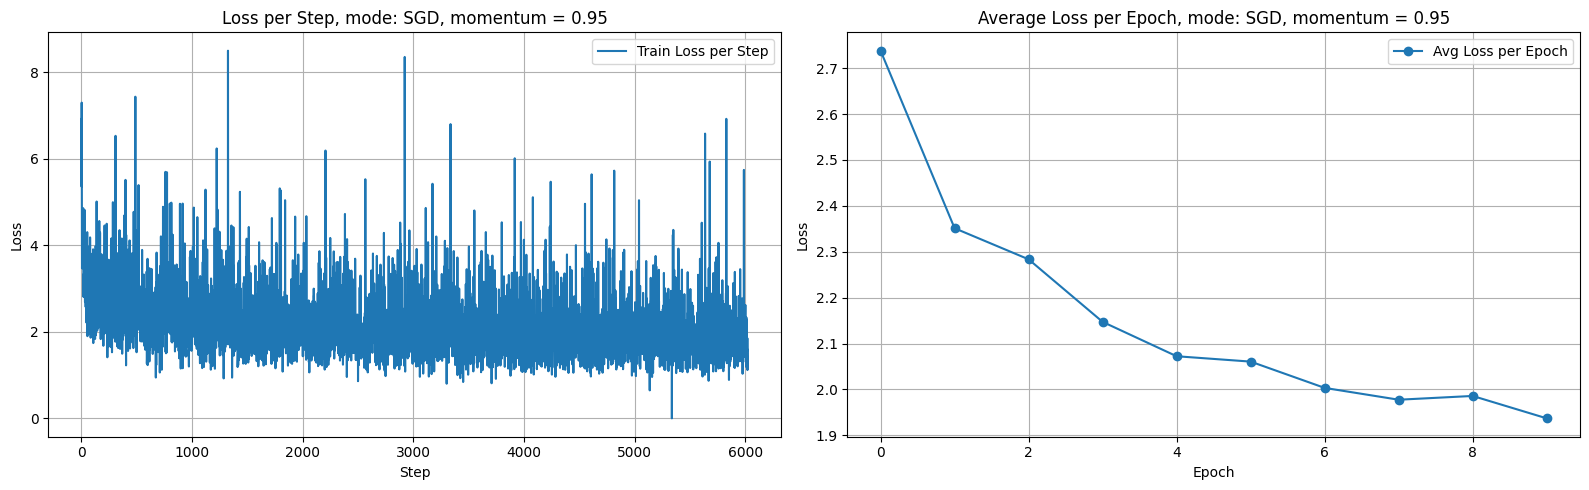

In [ ]:
for i in range(1, len(modes)):
  step_loss = steps_losses[i]
  epoch_loss = total_losses[i]
  visualize(step_loss, epoch_loss, modes[i])

Видим, что лучшая модель - третья с гиперпараметрами:  SGD, lr = 1e-3

#### (reg, 2.0) 4.4 Реализация NMS
Мы уже обсуждали алгоритм NMS на лекции, но если забылось, то вот отличная [статья](https://deepmachinelearning.ru/docs/Neural-networks/Object-detection/Non-maximum-supression).

In [57]:
def nms(boxes, scores_max, iou_threshold):
    bests = []
    sorted_ind = torch.argsort(scores_max, descending=True)
    boxes = boxes[sorted_ind]

    while boxes.size(0) > 0:
        cur_box = boxes[0].unsqueeze(0)
        bests.append(sorted_ind[0].item())

        if boxes.size(0) == 1:
            break

        ious = calculate_iou(cur_box, boxes[1:]).squeeze(0)
        mask = ious <= iou_threshold
        boxes = boxes[1:][mask]
        sorted_ind = sorted_ind[1:][mask]

    return bests

#### (reg, 2.0) 4.5 Реализация функции декодирования предсказаний
Нужно реализовать функцию для переовода offset + default_box/anchors, которые выдает модель, в xyxy bbox.

In [101]:
def decode_boxes(box_preds, default_boxes, variances=(0.1, 0.2), img_size=None):
    d_cx = (default_boxes[:,0] + default_boxes[:,2]) / 2
    d_cy = (default_boxes[:,1] + default_boxes[:,3]) / 2
    d_w = default_boxes[:,2] - default_boxes[:,0]
    d_h = default_boxes[:,3] - default_boxes[:,1]

    tx, ty, tw, th = box_preds[:,0], box_preds[:,1], box_preds[:,2], box_preds[:,3]

    cx = tx * d_w * variances[0] + d_cx
    cy = ty * d_h * variances[0] + d_cy
    w = torch.exp(tw * variances[1]) * d_w
    h = torch.exp(th * variances[1]) * d_h

    x_min = cx - 0.5 * w
    y_min = cy - 0.5 * h
    x_max = cx + 0.5 * w
    y_max = cy + 0.5 * h

    decoded = torch.stack([x_min, y_min, x_max, y_max], dim=1)

    return decoded

#### (reg, 0.5) 4.5 Визализация работы модели на val датасете
Выведит пару примеров детекции масок

In [102]:
from types import MethodType

@torch.no_grad()
def forward_no_postprocess(self, images):
    """Возвращает сырые предсказания без NMS."""
    original_image_sizes = [img.shape[-2:] for img in images]
    images, _ = self.transform(images)

    features_dict = self.backbone(images.tensors)
    features = list(features_dict.values())
    head_outputs = self.head(features)
    anchors = self.anchor_generator(images, features)

    return head_outputs, anchors, images.image_sizes, original_image_sizes

In [103]:
def predict(model):
  model.forward_no_postprocess = MethodType(forward_no_postprocess, model)
  model.to(DEVICE)
  model.eval()
  pred_results = []

  with torch.no_grad():
      for images, _ in test_loader:
          images = [img.to(DEVICE) for img in images]

          head_outputs, default_boxes, _, _ = model.forward_no_postprocess(images)
          pred_locs = head_outputs["bbox_regression"][0]
          pred_confs = head_outputs["cls_logits"][0]
          default_boxes = torch.cat(default_boxes, dim=0).to(DEVICE)

          for i in range(len(images)):
              locs = pred_locs[i]
              confs = pred_confs[i]

              if confs.dim() == 1:
                confs = confs.unsqueeze(0)

              probs = confs.softmax(dim=-1)
              if probs.size(0) == 1:
                scores, labels = probs[0,1:].max(dim=-1)
                labels = labels + 1
              else:
                scores, labels = probs[:,1:].max(dim=-1)
                labels = labels + 1

              mask = scores > 0.01
              locs = locs[mask]
              scores = scores[mask]
              labels = labels[mask]
              default_boxes_i = default_boxes[mask]

              if locs.numel() > 0:
                  decoded = decode_boxes(locs, default_boxes_i)
                  bests_ind = nms(decoded, scores, iou_threshold=0.5)

                  final_boxes = decoded[bests_ind]
                  final_scores = scores[bests_ind]
                  final_labels = labels[bests_ind]
              else:
                  final_boxes = torch.zeros((0,4))
                  final_scores = torch.zeros((0,))
                  final_labels = torch.zeros((0,), dtype=torch.long)

              pred_results.append({
                  "boxes": final_boxes.cpu(),
                  "scores": final_scores.cpu(),
                  "labels": final_labels.cpu()
              })
  return pred_results

#### (reg, 2.0) 4.6 Подсчет IoU
Для того чтобы оценить качество работы самой детекции чаще всего измеряют IoU. Пропустите вашу модель чере NMS и посчитайте IoU отонсительно Ground Truth. Вычисление IoU нужно реализовать самостоятелньо!

In [70]:
def calculate_iou(boxes1, boxes2):
    if boxes1.numel() == 0 or boxes2.numel() == 0:
        # try to infer dims safely
        n = 0 if boxes1.numel() == 0 else boxes1.size(0) if boxes1.dim() >= 1 else 1
        m = 0 if boxes2.numel() == 0 else boxes2.size(0) if boxes2.dim() >= 1 else 1
        return torch.zeros((n, m), device=boxes1.device)


    boxes1 = boxes1.unsqueeze(1)
    boxes2 = boxes2.unsqueeze(0)

    inter_x1 = torch.max(boxes1[...,0], boxes2[...,0])
    inter_y1 = torch.max(boxes1[...,1], boxes2[...,1])
    inter_x2 = torch.min(boxes1[...,2], boxes2[...,2])
    inter_y2 = torch.min(boxes1[...,3], boxes2[...,3])

    inter_w = (inter_x2 - inter_x1).clamp(min=0)
    inter_h = (inter_y2 - inter_y1).clamp(min=0)
    inter_area = inter_w * inter_h

    area1 = (boxes1[...,2]-boxes1[...,0])*(boxes1[...,3]-boxes1[...,1])
    area2 = (boxes2[...,2]-boxes2[...,0])*(boxes2[...,3]-boxes2[...,1])
    union = area1 + area2 - inter_area

    ious = inter_area / (union + 1e-6)
    return ious

In [105]:
ground_truths = []
for images, targets in test_loader:
    for t in targets:
        ground_truths.append(t)

In [104]:
means = []
all_pred_results = predict(model1)

In [71]:
for j, pred_results in enumerate(all_pred_results):
    all_ious = []
    for i in range(len(ground_truths)):

        gts = ground_truths[i]
        preds = pred_results

        gt_boxes = gts["boxes"][:, :4]
        pred_boxes = preds["boxes"][:, :4]

        if pred_boxes.dim() == 1:
            pred_boxes = pred_boxes.unsqueeze(0)
        if gt_boxes.dim() == 1:
            gt_boxes = gt_boxes.unsqueeze(0)


        pred_boxes = pred_boxes.to(DEVICE)
        gt_boxes = gt_boxes.to(DEVICE)

        def ensure_2d(boxes):
            if boxes.numel() == 0:
                return boxes.view(0,4)
            elif boxes.dim() == 1:
                return boxes.unsqueeze(0)
            return boxes

        pred_boxes = ensure_2d(pred_boxes)
        gt_boxes = ensure_2d(gt_boxes)


        ious = calculate_iou(pred_boxes, gt_boxes)


        if gt_boxes.numel() > 0 and pred_boxes.numel() > 0:
            max_iou_per_gt = ious.max(dim=0)[0]
            all_ious.extend(max_iou_per_gt.cpu().tolist())
        else:
            all_ious.extend([0.0]*gt_boxes.size(0))

    mean_iou = sum(all_ious) / len(all_ious) if len(all_ious) > 0 else 0.0
    means.append(mean_iou)

Mean IoU for model 1: 0.0
Mean IoU for model 2: 0.0
Mean IoU for model 3: 0.0
Mean IoU for model 4: 0.0026633230174038618
Mean IoU for model 5: 0.0
Mean IoU for model 6: 0.001976619333825784
Mean IoU for model 7: 0.0
Mean IoU for model 8: 0.0
Mean IoU for model 9: 0.0
Mean IoU for model 10: 0.0
Mean IoU for model 11: 0.0
Mean IoU for model 12: 0.0
Mean IoU for model 13: 0.0
Mean IoU for model 14: 0.0
Mean IoU for model 15: 0.0
Mean IoU for model 16: 0.0
Mean IoU for model 17: 0.0
Mean IoU for model 18: 0.0
Mean IoU for model 19: 0.0
Mean IoU for model 20: 0.0
Mean IoU for model 21: 0.0
Mean IoU for model 22: 0.0
Mean IoU for model 23: 0.0
Mean IoU for model 24: 0.0
Mean IoU for model 25: 0.0
Mean IoU for model 26: 0.0
Mean IoU for model 27: 0.0
Mean IoU for model 28: 0.0
Mean IoU for model 29: 0.0
Mean IoU for model 30: 0.0
Mean IoU for model 31: 0.0
Mean IoU for model 32: 0.0
Mean IoU for model 33: 0.0
Mean IoU for model 34: 0.0
Mean IoU for model 35: 0.002919920407138765
Mean IoU for

KeyboardInterrupt: 

#### (reg, 2.0) 4.7 Подсчет mAP
Про `Mean Average Precision` вы точно слышали из прошлого курса. Считается немного модифицированный `PR AUC` по всем наблюдениям одного класса (у нас он только один, фон не считается) и получаем `AP`, а дальше усредняем `AP` по всем классам и получаем `mAP`. [Тут](https://learnopencv.com/mean-average-precision-map-object-detection-model-evaluation-metric/) пример на пальцах. Расчет mAP тоже нужно реализовать самостоятельно.

In [ ]:
def mAP(all_pred_results, ground_truths, device, iou_threshold=0, score_threshold=0):
    pred_boxes, pred_scores, pred_image_ids = [], [], []
    gt_boxes, gt_image_ids = [], []

    for img_id, (pred, gt) in enumerate(zip(all_pred_results, ground_truths)):
        boxes = pred["boxes"]
        scores = pred["scores"]

        boxes = boxes.squeeze(0) if boxes.dim() == 3 and boxes.size(0) == 1 else boxes
        gt_boxes_img = gt["boxes"].squeeze(0) if gt["boxes"].dim() == 3 and gt["boxes"].size(0) == 1 else gt["boxes"]

        if scores.ndim == 0:
            scores = scores.unsqueeze(0)
        if boxes.ndim == 1:
            boxes = boxes.unsqueeze(0)
        if len(scores) != len(boxes):
            min_len = min(len(scores), len(boxes))
            boxes, scores = boxes[:min_len], scores[:min_len]

        mask = scores >= 0
        boxes, scores = boxes[mask], scores[mask]

        pred_boxes.append(boxes)
        pred_scores.append(scores)
        pred_image_ids.extend([img_id] * len(scores))

        gt_boxes.append(gt_boxes_img)
        gt_image_ids.extend([img_id] * len(gt_boxes_img))

    if not pred_boxes or not gt_boxes:
        return 0.0

    pred_boxes = torch.cat(pred_boxes).to(device)
    pred_scores = torch.cat(pred_scores).to(device)
    sorted_idx = torch.argsort(pred_scores, descending=True)

    pred_boxes = pred_boxes[sorted_idx]
    pred_scores = pred_scores[sorted_idx]
    pred_image_ids = [pred_image_ids[i] for i in sorted_idx]

    total_gts = sum(len(b) for b in gt_boxes)
    tp = torch.zeros(len(pred_boxes), device=device)
    fp = torch.zeros(len(pred_boxes), device=device)
    used = {i: torch.zeros(len(gt_boxes[i]), device=device) for i in range(len(gt_boxes))}

    for i, (box, img_id) in enumerate(zip(pred_boxes, pred_image_ids)):
        gts = gt_boxes[img_id].to(device)

        print(box.shape, gts.shape, scores)
        if len(gts) == 0:
            fp[i] = 1
            continue

        ious = calculate_iou_matrix(box.unsqueeze(0), gts).squeeze(0)
        max_iou, max_idx = torch.max(ious, dim=0)

        if max_iou >= iou_threshold and used[img_id][max_idx] == 0:
            tp[i] = 1
            used[img_id][max_idx] = 1
        else:
            fp[i] = 1

    tp_cum = torch.cumsum(tp, dim=0)
    fp_cum = torch.cumsum(fp, dim=0)
    recalls = tp_cum / total_gts
    precisions = tp_cum / (tp_cum + fp_cum + 1e-6)

    ap = 0.0
    for t in torch.arange(0, 1.1, 0.1):
        p = precisions[recalls >= t].max() if torch.any(recalls >= t) else 0
        ap += p / 11.0

    return float(ap)

### 5. Обучение модели на базе собственного претрейна
**Все пункты дальше необязательные! И их можно делать, только если у вас хоть чуть-чуть сошелся лосс и модель классифицирует объекты лучше рандома!**

#### 5.1 Дообучение вашего претрейна

In [ ]:
# YOUR CODE HERE

#### 5.2 Визуализация эксперимента

In [ ]:
# YOUR CODE HERE

#### 5.3 Подсчет IoU

In [ ]:
# YOUR CODE HERE

#### 5.3 Подсчет mAP

In [ ]:
# YOUR CODE HERE